In [7]:

# IMPORT NECESSARY LIBRARIES

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
# ====================================================================
# PART 1: LOAD IMAGES INTO ARRAYS
# ====================================================================

DATASET_PATH = DATASET_PATH = r"D:\realwaste" # Update this path to your dataset location
IMG_HEIGHT, IMG_WIDTH = 128, 128

def load_dataset(dataset_path, img_height, img_width):
    X, y = [], []
    class_names = sorted(os.listdir(dataset_path))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_file in tqdm(os.listdir(class_dir), desc=f'Loading {class_name}'):
            img_path = os.path.join(class_dir, img_file)
            try:
                img = image.load_img(img_path, target_size=(img_height, img_width))
                img_array = image.img_to_array(img) / 255.0
                X.append(img_array)
                y.append(label)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
    return np.array(X), np.array(y), class_names

X, y, class_names = load_dataset(DATASET_PATH, IMG_HEIGHT, IMG_WIDTH)
num_classes = len(class_names)
print(f"Dataset loaded: {X.shape[0]} images, {num_classes} classes")

Loading Cardboard:   0%|          | 0/461 [00:00<?, ?it/s]

Loading realwaste-main: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

Skipping D:\realwaste\realwaste-main\README.md: cannot identify image file <_io.BytesIO object at 0x0000025EF3957BF0>


Dataset loaded: 4752 images, 10 classes


In [3]:
# ====================================================================
# PART 2: TRAIN-VALIDATION-TEST SPLIT (70%-15%-15%)
# ====================================================================

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (50-50 split of 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 3326
Validation samples: 713
Testing samples: 713


In [4]:
# ====================================================================
# PART 3: BUILD AND FINE-TUNE THE VGG16 MODEL
# ====================================================================

# Define base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze base layers (for initial training)
for layer in base_model.layers:
    layer.trainable = False

# Build model on top of VGG16 base
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Learning rate schedule function
def lr_schedule(epoch, lr):
    """Decay learning rate after certain epochs."""
    if epoch < 5:
        return lr
    elif epoch < 10:
        return lr * 0.5
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Compile model for initial training (frozen base)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("========== Initial Training: Top Layers Only ==========")
history_stage1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[lr_scheduler],
    verbose=1
)


========== Initial Training: Top Layers Only ==========

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.3310 - loss: 1.8338 - val_accuracy: 0.4965 - val_loss: 1.4778 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.4889 - loss: 1.4280 - val_accuracy: 0.5344 - val_loss: 1.3220 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.5451 - loss: 1.2820 - val_accuracy: 0.5975 - val_loss: 1.1979 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.5815 - loss: 1.1917 - val_accuracy: 0.6059 - val_loss: 1.1696 - learning_rate: 0.0010

Epoch 5: Le

In [8]:
# ====================================================================
# PART 4: UNFREEZE BASE LAYERS AND FINE-TUNE ENTIRE MODEL
# ====================================================================

# Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

# Use a smaller learning rate for fine-tuning
optimizer_finetune = Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer_finetune, loss='categorical_crossentropy', metrics=['accuracy'])

print("\n========== Fine-Tuning: Unfrozen Base Layers ==========")
history_stage2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)],
    verbose=1
)


========== Fine-Tuning: Unfrozen Base Layers ==========
Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.6744 - loss: 0.9067 - val_accuracy: 0.7139 - val_loss: 0.8343 - learning_rate: 1.0000e-05
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 511s 5s/step - accuracy: 0.7688 - loss: 0.6666 - val_accuracy: 0.7181 - val_loss: 0.7809 - learning_rate: 1.0000e-05
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 518s 5s/step - accuracy: 0.8208 - loss: 0.5230 - val_accuracy: 0.7251 - val_loss: 0.7454 - learning_rate: 1.0000e-05
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 526s 5s/step - accuracy: 0.8632 - loss: 0.4000 - val_accuracy: 0.7658 - val_loss: 0.6816 - learning_rate: 1.0000e-05
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 520s 5s/step - accuracy: 0.8975 - loss: 0.2997 - val_accuracy: 0.7518 - val_loss: 0.6870 - learning_rate: 1.0000e-05
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9138 - loss: 0.2637
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-0

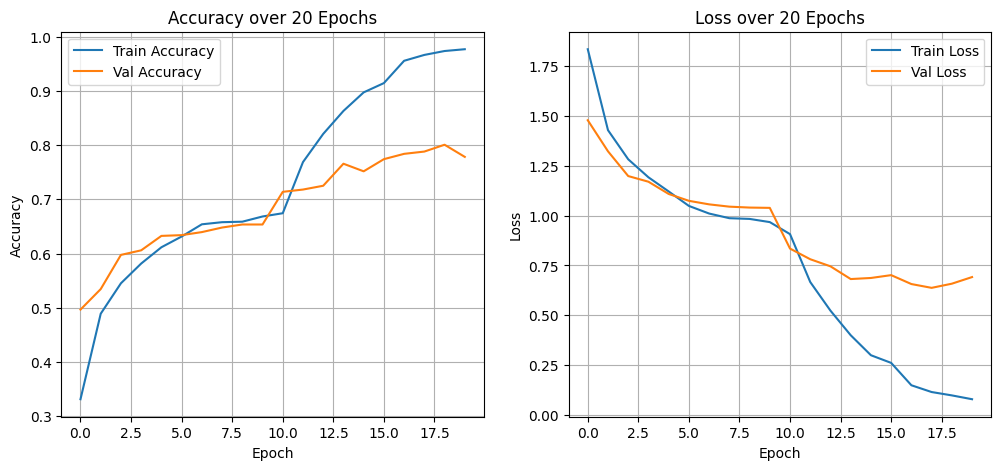

In [9]:
# ====================================================================
# PART 5: TRAINING METRICS
# ====================================================================

train_acc = history_stage1.history['accuracy'] + history_stage2.history['accuracy']
val_acc = history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']
train_loss = history_stage1.history['loss'] + history_stage2.history['loss']
val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Accuracy over 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss over 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# ====================================================================
# PART 6: EVALUATION ON TEST SET
# ====================================================================

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Evaluate model performance
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n================ Evaluation Results ================")
print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

================ Evaluation Results ================
Train Accuracy: 99.58%
Train Loss: 0.0317
Test Accuracy: 80.08%
Test Loss: 0.6681
Precision: 0.8182
Recall: 0.8021
F1-Score: 0.8077


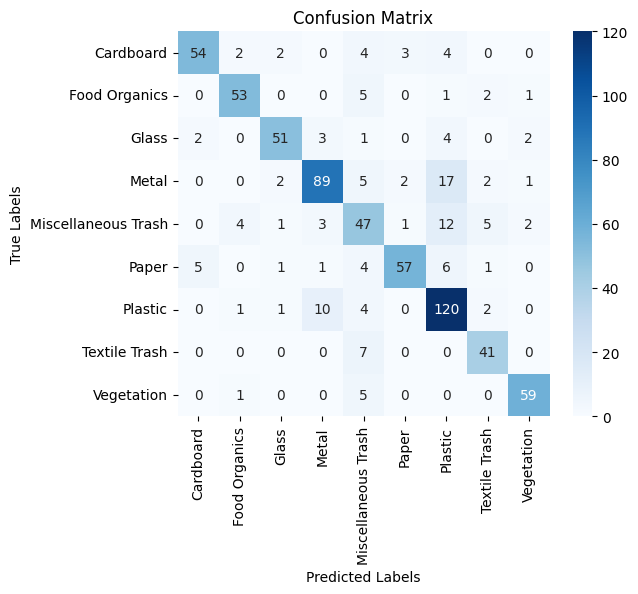


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.89      0.78      0.83        69
      Food Organics       0.87      0.85      0.86        62
              Glass       0.88      0.81      0.84        63
              Metal       0.84      0.75      0.79       118
Miscellaneous Trash       0.57      0.63      0.60        75
              Paper       0.90      0.76      0.83        75
            Plastic       0.73      0.87      0.79       138
      Textile Trash       0.77      0.85      0.81        48
         Vegetation       0.91      0.91      0.91        65

           accuracy                           0.80       713
          macro avg       0.82      0.80      0.81       713
       weighted avg       0.81      0.80      0.80       713



In [12]:
# ====================================================================
# PART 7: CONFUSION MATRIX & REPORT
# ====================================================================

# Ensure y_true and y_pred are numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Identify unique labels actually present in y_true
unique_labels = np.unique(y_true)
filtered_class_names = [class_names[i] for i in unique_labels]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=unique_labels, target_names=filtered_class_names))